In [14]:
import os
import math
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from optimization import (SequenceSignal, 
                          transformer_model, 
                          train_val_loops)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import pearsonr
from sklearn.metrics import (precision_score, recall_score, auc, 
                             precision_recall_curve, PrecisionRecallDisplay)

## Train the CNN + Transformer model

In [15]:
# Global variables
DATA_DIR=Path('../ML_datasets/ATAC_data/')
X_TRAIN_PATH = DATA_DIR.joinpath('dataset_1kb_300bp_train_augmented_encoding.npy')
Y_TRAIN_PATH = DATA_DIR.joinpath('train_target_Z_scores.npy')
X_VAL_PATH = DATA_DIR.joinpath('dataset_1kb_300bp_val_encoding.npy')
Y_VAL_PATH = DATA_DIR.joinpath('val_target.npy')
N_VAL_EXAMPLES = np.load(Y_VAL_PATH).shape[0]
N_TRAIN_EXAMPLES = np.load(Y_TRAIN_PATH).shape[0]
Z_SCORE_INVERSE_MEANS = DATA_DIR.joinpath('sample_means.npy')
Z_SCORE_INVERSE_STD = DATA_DIR.joinpath('sample_stds.npy')

BATCH_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataloaders = SequenceSignal.load_dataset(X_TRAIN_PATH, 
                                          Y_TRAIN_PATH, 
                                          X_VAL_PATH, 
                                          Y_VAL_PATH, 
                                          BATCH_SIZE, 
                                          device = DEVICE)

In [16]:
N_EPOCHS = 30
PATIENCE = 20
OUTPUT_SHAPE = 9
CRITERION = torch.nn.MSELoss()
CHECKPOINT_NAME = DATA_DIR.joinpath('ATAC_transformer.pth')

model = transformer_model.TransformerCNNMixtureModel(n_conv_layers = 4, 
                                                     n_filters = [256, 60, 60, 120], 
                                                     kernel_sizes = [7, 3, 5, 3], 
                                                     dilation = [1, 1, 1, 1], 
                                                     drop_conv = 0.1, 
                                                     n_fc_layers = 2, 
                                                     drop_fc = 0.4, 
                                                     n_neurons = [256, 256], 
                                                     output_size = OUTPUT_SHAPE, 
                                                     drop_transformer=0.2, 
                                                     input_size=4, 
                                                     n_encoder_layers = 2, 
                                                     n_heads=8, 
                                                     n_transformer_FC_layers=256)

model.to(device=DEVICE)
summary(model)

Layer (type:depth-idx)                                            Param #
TransformerCNNMixtureModel                                        --
├─ModuleList: 1-1                                                 --
│    └─Sequential: 2-1                                            --
│    │    └─ConvPoolingBlock: 3-1                                 7,936
│    └─Sequential: 2-2                                            --
│    │    └─ConvPoolingBlock: 3-2                                 46,260
│    └─Sequential: 2-3                                            --
│    │    └─ConvPoolingBlock: 3-3                                 18,180
│    └─Sequential: 2-4                                            --
│    │    └─ConvPoolingBlock: 3-4                                 21,960
├─PositionalEncoding: 1-2                                         --
├─TransformerEncoder: 1-3                                         --
│    └─ModuleList: 2-5                                            --
│    │    └─Tr

In [17]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-3, weight_decay = 1e-4)
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                             epochs = N_EPOCHS, 
                                             max_lr = 1e-3, 
                                             steps_per_epoch = math.ceil(N_TRAIN_EXAMPLES / dataloaders[0].batch_size), 
                                             pct_start = 0.1, 
                                             anneal_strategy = 'linear')
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    base_momentum: 0.85
    betas: (0.95, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 4e-05
    lr: 4e-05
    max_lr: 0.001
    max_momentum: 0.95
    maximize: False
    min_lr: 4e-09
    weight_decay: 0.0001
)


In [18]:
if not os.path.exists(CHECKPOINT_NAME):
    
    output = train_val_loops.train_N_epochs(model, optimizer, 
                                            criterion = CRITERION, 
                                            train_loader = dataloaders[0], 
                                            valid_loader = dataloaders[1], 
                                            num_epochs = N_EPOCHS, 
                                            patience = PATIENCE, 
                                            model_path = CHECKPOINT_NAME, 
                                            lr_scheduler = lr_scheduler, 
                                            means_path = Z_SCORE_INVERSE_MEANS, 
                                            stds_path = Z_SCORE_INVERSE_STD, 
                                            DEVICE = DEVICE)
else:
    
    training_state = torch.load(CHECKPOINT_NAME, 
                                weights_only = True, 
                                map_location = DEVICE)
    
    optimizer.load_state_dict(training_state['optimizer'])
    lr_scheduler.load_state_dict(training_state['lr_sched'])
    model.load_state_dict(training_state['network'])
    best_valid_loss = training_state['best_valid_loss']

In [19]:
# Load mean and std used for z-score normalization
#X_VAL_PATH = DATA_DIR.joinpath('dataset_1kb_300bp_test_encoding.npy')
#Y_VAL_PATH = DATA_DIR.joinpath('test_target.npy')
#N_VAL_EXAMPLES = np.load(Y_VAL_PATH).shape[0]

#dataloaders = SequenceSignal.load_dataset(X_TRAIN_PATH, 
#                                          Y_TRAIN_PATH, 
#                                          X_VAL_PATH, 
#                                          Y_VAL_PATH, 
#                                          BATCH_SIZE, 
#                                          device = DEVICE)

Y_PREDICT_PATH = DATA_DIR.joinpath('y_predict_ATAC.npy')
means = torch.from_numpy(np.load(Z_SCORE_INVERSE_MEANS)).float().to(DEVICE)
stds = torch.from_numpy(np.load(Z_SCORE_INVERSE_STD)).float().to(DEVICE)

model.eval()
y_predict = torch.zeros((N_VAL_EXAMPLES, OUTPUT_SHAPE), device = DEVICE)
y_true = torch.zeros((N_VAL_EXAMPLES, OUTPUT_SHAPE), device = DEVICE)

with torch.inference_mode():
    
    for i, data in enumerate(dataloaders[1], 0):
        inputs, labels = data
        outputs = model(inputs)

        outputs_denorm = outputs * stds + means

        start_idx = i * BATCH_SIZE
        end_idx = start_idx + BATCH_SIZE

        y_predict[start_idx:end_idx] = outputs_denorm
        y_true[start_idx:end_idx] = labels

y_true_array = y_true.cpu().numpy()
y_predict_array = y_predict.cpu().numpy()

print(CRITERION(y_predict, y_true))
np.save(Y_PREDICT_PATH, y_predict_array)

tensor(0.9919, device='cuda:0')


In [20]:
for j in range(OUTPUT_SHAPE):
    print(pearsonr(y_true_array[:, j], y_predict_array[:, j]))

PearsonRResult(statistic=0.6683887, pvalue=0.0)
PearsonRResult(statistic=0.6802765, pvalue=0.0)
PearsonRResult(statistic=0.71187115, pvalue=0.0)
PearsonRResult(statistic=0.69475204, pvalue=0.0)
PearsonRResult(statistic=0.6647593, pvalue=0.0)
PearsonRResult(statistic=0.7166063, pvalue=0.0)
PearsonRResult(statistic=0.7295735, pvalue=0.0)
PearsonRResult(statistic=0.7087913, pvalue=0.0)
PearsonRResult(statistic=0.70906407, pvalue=0.0)


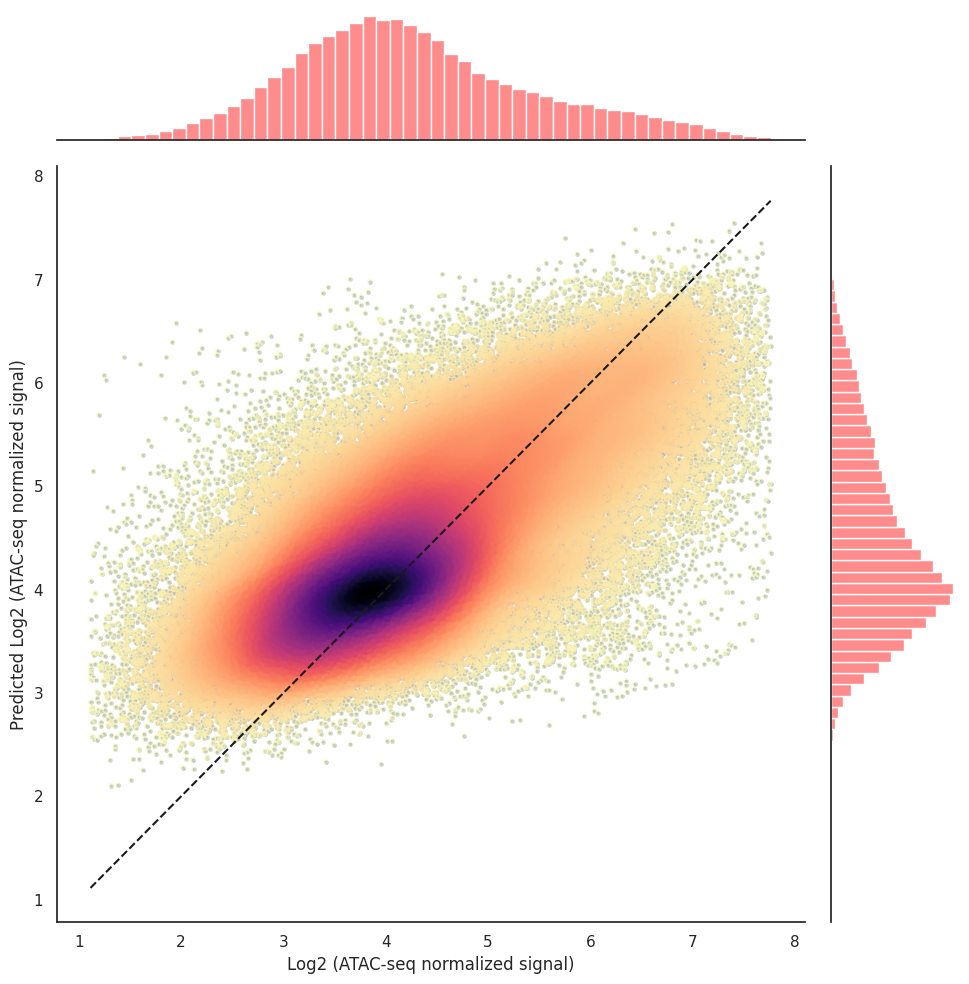

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd

# Set plot theme
sns.set_theme(style="white")  # Change to "darkgrid", "white", "ticks", etc. as desired

contexts = ['E5', 'E11', 'E13', 'EAD', 'HID', 'WID', 'LB', 'AB', 'O']

C = 4
x = y_true_array[:, C]
y = y_predict_array[:, C]
xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

data = pd.DataFrame({'True Values': x, 'Predicted Values': y, 'Density': z})

# Create jointplot
g = sns.jointplot(
    data=data, x='True Values', y='Predicted Values', 
    kind="scatter", palette="magma_r", alpha=0.7, s=10,
    marginal_kws=dict(bins=50, fill=True, color='#FF6666'), 
    height = 10
)

# Customize plot
g.plot_joint(plt.scatter, c=data['Density'], cmap="magma_r", s=10, alpha=0.5)
g.ax_joint.plot([min(x), max(x)], [min(x), max(x)], 'k--', linewidth=1.5)
g.ax_joint.set_xlabel("Log2 (ATAC-seq normalized signal)")
g.ax_joint.set_ylabel("Predicted Log2 (ATAC-seq normalized signal)")
g.ax_joint.set_title(f'{contexts[C]}', pad=70)

# Save to PDF
plt.savefig("jointplot_output.png", dpi=300, bbox_inches='tight')
plt.show()